In [1]:
#import Library 
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture
from copy import copy, deepcopy


# 1.1 K-means clustering

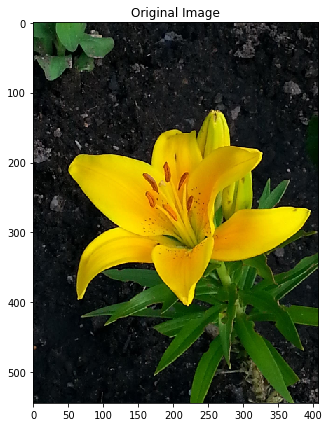

In [2]:
# Read an image
img = cv2.cvtColor(cv2.imread('yellowlily.png'), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(7,7))
plt.imshow(img)
plt.title("Original Image")
plt.show()

# Arrange img to a feature matrix and convert it to np.float32
Z = img.reshape((-1,3))
traind = np.float32(Z)

#normalizing the RGB matrix
traind /= 255.0


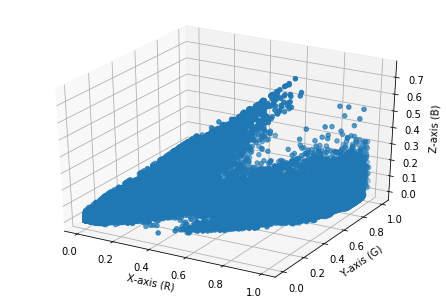

In [3]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(traind[:, 0], traind[:, 1],traind[:, 2])
ax.set_xlabel('X-axis (R)')
ax.set_ylabel('Y-axis (G)')
ax.set_zlabel('Z-axis (B)')
plt.show()

In [4]:
# The code in the above website was only used as reference
#source: https://codereview.stackexchange.com/questions/205097/k-means-using-numpy
def k_means(traind, k, num_iter):
 
    max_val = np.max(traind, axis=0)
    min_val = np.min(traind, axis=0)

    samples = traind.shape[0]
    d = traind.shape[1] # RGB #3

    # labels : array containing labels for data points, randomly initialized 
    # we have 2 labels here
    labels = np.random.randint(low=0, high=k, size=samples)
    
    # randomly initialized s.t. data_min <= centroid < data_max
    # choose random number btween 0 and 1
    centroids = np.random.uniform(low=min_val, high=max_val, size=(k,d)) #2x3

    # start k-means 
    for i in range(num_iter):
        # return the norm distance btween each point and the 2 centroids # 2.img.shape[1]
        #axis 1 means takes noem row wise
        distances = np.array(
            [np.linalg.norm(traind - c, axis=1) for c in centroids]) 
        #print(distances)
        #print(distances.shape) # 2ximg.shape[1]
        # new_labels : computed by finding centroid with minimal distance
        labels = np.argmin(distances, axis=0) #for each col (data points) find wich centroids is closer

        for c in range(k):
            # computing centroids by taking the mean over associated data points
            centroids[c] = np.mean(traind[labels == c], axis=0) #sum all data points(col) that belong to this centroids to find new mean
    return labels,centroids           
                

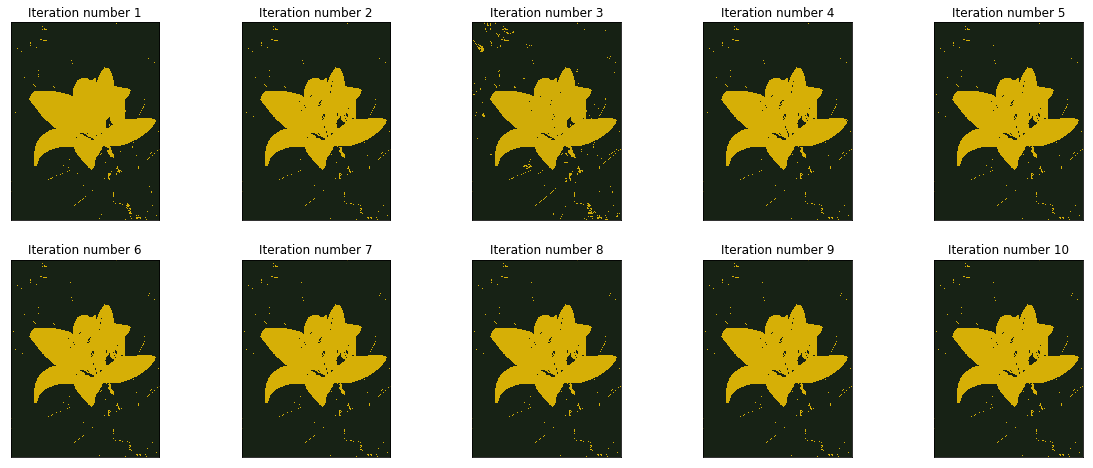

In [5]:
# set figure size
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,8))
#sorce: http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
axes_list = [item for sublist in axes for item in sublist]
# loop to display the 10 first iteration
for i in range(1,11):
    
    label,centers=k_means(traind,2,i)
    #convert to int(Unsigned integer (0 to 255))
    centers *= 255.0
    centers = np.uint8(centers)
    #print(centers.shape)
    # when ever the label is 1 we set it to be the same color as c 1, and label 0 as c2
    segmented_image= centers[label.flatten()]
    segmented_image = segmented_image.reshape(img.shape)
    
    
    ax = axes_list.pop(0)
    ax = plt.subplot(2, 5, i)
    plt.imshow(segmented_image)
    ax.set_title("Iteration number " + str(i)), plt.xticks([]), plt.yticks([])
    
 

[[0.09320687 0.13705875 0.08284835]
 [0.83954418 0.68964732 0.02425681]]
[[ 23.76775123  34.9499812   21.12632867]
 [214.08376515 175.86006582   6.18548574]]


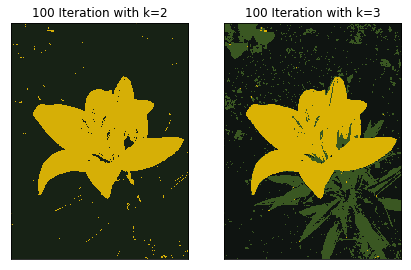

In [6]:
#showing the segmented image after 100 runs
label,centers=k_means(traind,2,100)
print(centers)
centers *= 255.0
print(centers)
centers = np.uint8(centers)
segmented_image = centers[label.flatten()]
segmented_image = segmented_image.reshape(img.shape)

label,centers=k_means(traind,3,100)
centers *= 255.0
centers = np.uint8(centers)
segmented_image2 = centers[label.flatten()]
segmented_image2 = segmented_image2.reshape(img.shape)



plt.figure(figsize=(7,7))
plt.subplot(121), plt.imshow(segmented_image)
plt.title("100 Iteration with k=2"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(segmented_image2)
plt.title("100 Iteration with k=3"), plt.xticks([]), plt.yticks([])
plt.show()



# 1.2 Expectation Maximization - Gaussian Mixture Models

iteration1
iteration2
iteration3
iteration4
iteration5
iteration6
iteration7
iteration8
iteration9
iteration10


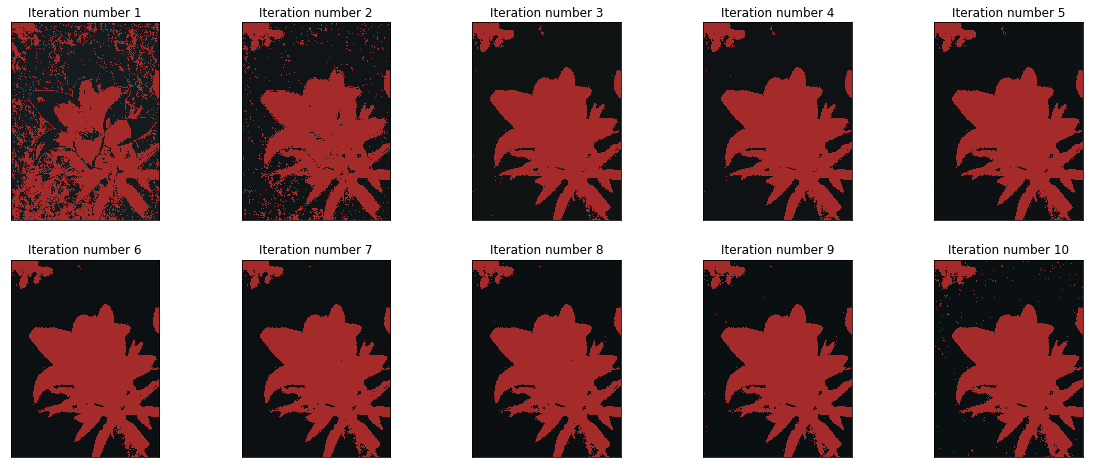

In [24]:
import math
# Read an image
img = cv2.cvtColor(cv2.imread('yellowlily.png'), cv2.COLOR_BGR2RGB)

# Arrange img to a feature matrix and convert it to np.float32
Z = img.reshape((-1,3))
traind = np.float32(Z)

#normalizing the RGB matrix
traind /= 255.0
#print(traind)


traind = np.sort(traind)


# initialization
def initialization(traind,k):
    #calling k means with 1 iteration to get 2 random means a random labels
    label,centers=k_means(traind,k,1)
    #mean = centers
    mean = np.random.uniform(low=0, high=1, size=(2,traind.shape[1]))
    mean[0] = np.mean(traind[:int(len(traind)/2)], axis=0)
    mean[1] = np.mean(traind[int(len(traind)/2):], axis=0)
    label = np.matrix(label)
    label = label[:,np.newaxis]

    samples=traind.shape[0]
    d=traind.shape[1]
    
    # ine itialize a random covariance matrix based on the mean
    covar = np.random.uniform(low=0, high=1, size=(k,d,d))
    for i in range(0,k):
        total = 0
        for j in range(0,samples):
            x_m = traind[j]-mean[i]
            x_m = x_m[:,np.newaxis]
            curr = np.matmul(x_m,x_m.T)
            total = curr+total
        covar[i]=np.divide(total, samples)
    
    #initialize weight for 1st run w=1/2 (50% of it being in each cluster)
    w= np.random.uniform(low=0, high=1, size=(k,1))
    w[0] = 0.5
    w[1] = 0.5
    
    return w,mean,covar

# a method that will return the gaussian prp N
def gauss(traind,meani,covari):
    gss_list =[]
    det=np.linalg.det(covari)
    temp = 1/(np.sqrt(((2*math.pi)**3)*det))
    for j in range(0,traind.shape[0]):
        x_m = traind[j]-meani
        x_m = x_m[:,np.newaxis]
        inv=np.linalg.inv(covari)
        curr = np.matmul(x_m.T,inv)
        curr2 = np.matmul(curr,x_m)
        exp = temp*np.exp(-0.5*curr2)
        gss_list.append(exp)
    return gss_list

# the E-Step
# this will return 2 cluster each with their own probability list
def expectation(traind,mean,covar,w,k):
    sum_list=[]
    num_list=[]
    cluster_EM1=[]
    cluster_EM2=[]
    prp_EM1=[]
    prp_EM2=[]
    label=[]
    
    #conditional probability is calculated according to the slide formula for i in range(0,k):
    for i in range(0,k):
        gss_prp = gauss(traind,mean[i],covar[i])
        sum_gss = w[i]*np.sum(gss_prp)
        sum_list.append(sum_gss)

    sum_dun = np.sum(sum_list)
    
    # compute the probability and then assign point to the cluster with the larger probability
    # labels is alos assigned here ( used for displaying the segmented img)
    for i in range(0,k):
        gss_prp = gauss(traind,mean[i],covar[i])
        num = w[i]*gss_prp
        num /= sum_dun
        num_list.append(num)
    num_list = np.array(num_list)

    for i in range(0,num_list.shape[1]):
        if num_list[0][i] > num_list[1][i]:
            label.append(0)
            cluster_EM1.append(traind[i])
            prp_EM1.append(num_list[0][i])
        else:
            label.append(1)
            cluster_EM2.append(traind[i])
            prp_EM2.append(num_list[1][i])

    return label,prp_EM1,prp_EM2,cluster_EM1,cluster_EM2
    

# the M-Step
def maximization(label,prp_EM1,prp_EM2,cluster_EM1,cluster_EM2,k):
    
   # recompute the weight based on the probability
    Weight[0] = np.sum(prp_EM1)/len(prp_EM1)
    Weight[1] = np.sum(prp_EM2)/len(prp_EM2) 
   
    
    # Recomputing the mean for each cluster
    total_sum=0
    for i in range(0,len(cluster_EM1)):
        temp6=cluster_EM1[i]*prp_EM1[i]
        total_sum = total_sum+temp6
    total_sum /= np.sum(prp_EM1)
    Mean[0]=total_sum
    
    total_sum=0
    for i in range(0,len(cluster_EM2)):
        temp6=cluster_EM2[i]*prp_EM2[i]
        total_sum = total_sum+temp6
    total_sum /= np.sum(prp_EM2)
    Mean[1]=total_sum
    
        
   # Recomputing the covariance matrix for each cluster
    total_sum2=0
    for i in range(0,len(cluster_EM1)):
            x_m_i = cluster_EM1[i]-Mean[0]
            x_m_i = x_m_i[:,np.newaxis]
            curr5 = np.matmul(x_m_i,x_m_i.T)
            curr6=curr5*prp_EM1[i]
            total_sum2 = total_sum2+curr6
    total_sum2 /= np.sum(prp_EM1)
    Sigma[0] = total_sum2       
    
    total_sum2=0
    for i in range(0,len(cluster_EM2)):
            x_m_i = cluster_EM2[i]-Mean[1]
            x_m_i = x_m_i[:,np.newaxis]
            curr5 = np.matmul(x_m_i,x_m_i.T)
            curr6=curr5*prp_EM2[i]
            total_sum2 = total_sum2+curr6
    total_sum2 /= np.sum(prp_EM2)
    Sigma[1] = total_sum2  
    #print(Sigma)

    
    return Weight, Mean, Sigma

# plooting the img for the first 10 iterations
k=2
Weight,Mean,Sigma=initialization(traind,k)
 

# # set figure size
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,8))
#sorce: http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
axes_list = [item for sublist in axes for item in sublist]

for i in range(1,11):
    
    label,prp_EM1,prp_EM2,cluster_EM1,cluster_EM2 = expectation(traind,Mean,Sigma,Weight,k)
    Weight,Mean,Sigma = maximization(label,prp_EM1,prp_EM2,cluster_EM1,cluster_EM2,k)
    
    print("iteration" + str(i))
    mean_print = deepcopy(Mean)
    mean_print *= 255.0 
    # the color can be very similr sometime so used this to make the segmrnted img more clear
    mean_print[1] = (165,42,42) #(220, 20, 60)
    mean_print = np.uint8(mean_print)
    segmented_image = mean_print[label]
    segmented_image = segmented_image.reshape(img.shape)
    ax = axes_list.pop(0)
    ax = plt.subplot(2, 5, i)
    plt.imshow(segmented_image)
    #plt.title("Iteration number " + str(i)), plt.xticks([]), plt.yticks([])
    ax.set_title("Iteration number " + str(i)), plt.xticks([]), plt.yticks([])
    #plt.show()    
    

Q) Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?

K-means works with the assumption that the data is distributed in a spherical position. Thus, K-means and EM would achieve a similar result if we had an identical covariance matrix for each cluster in EM. In other word if the data clusters were spherical.  In this case the EM labeling process will depends mostly on the cluster means distance and will end up reaching a behavior similar to k means. 

As seen from the results above k-mean and EM provide different segmentation result providing a similar random initialization and the same k size.  k-means were only able to segment the yellow part of the flower from the background when k was set 2. With k being set to 3 k- means were able to distinguish the green part of the flower as well. As for the GMM it started with segmenting only the yellow part but we increased the iteration it was able to include the green part as a part of the cluster and successfully classified these two different flowers part using only k of size 2.  



# Part 2

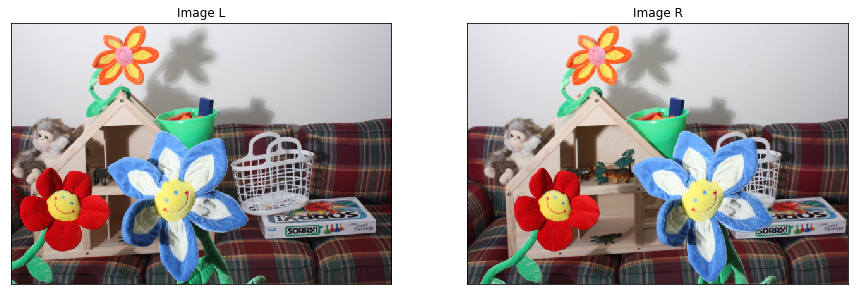

In [8]:
# Read an image
imgL = cv2.cvtColor(cv2.imread('im1 (1).png'), cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(cv2.imread('im0 (1).png'), cv2.COLOR_BGR2RGB)





plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL)
plt.title("Image L"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR)
plt.title("Image R"), plt.xticks([]), plt.yticks([])
plt.show()

[[-1.4345156e-18 -1.0000000e+00  1.8400000e+02]
 [-1.4345156e-18 -1.0000000e+00  1.8400000e+02]
 [-2.7870790e-18 -1.0000000e+00  2.2600000e+02]
 ...
 [-3.7796124e-18 -1.0000000e+00  2.6900000e+02]
 [-4.3273619e-18 -1.0000000e+00  2.8600000e+02]
 [-1.3868853e-19 -1.0000000e+00  1.5600000e+02]]


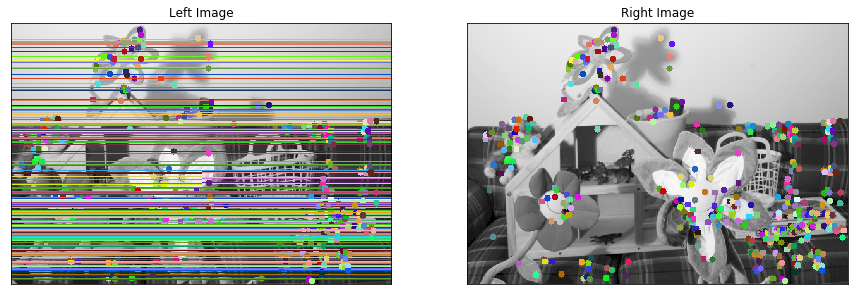

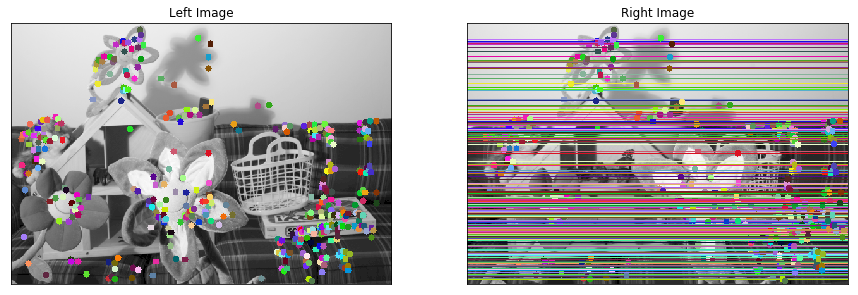

In [9]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2, y0, x0, x1

# load left and right images
imgL = cv2.imread("im1 (1).png", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("im0 (1).png", cv2.IMREAD_GRAYSCALE)

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Now, we want to match keypoints and remove matches on repeatative structure.
# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2) # query image, train image

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) 


# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1,y1,x0,x1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
print(linesR)
# draw lines
imgR2, imgL2,y1,x0,x1 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Random point is :
[209  36]


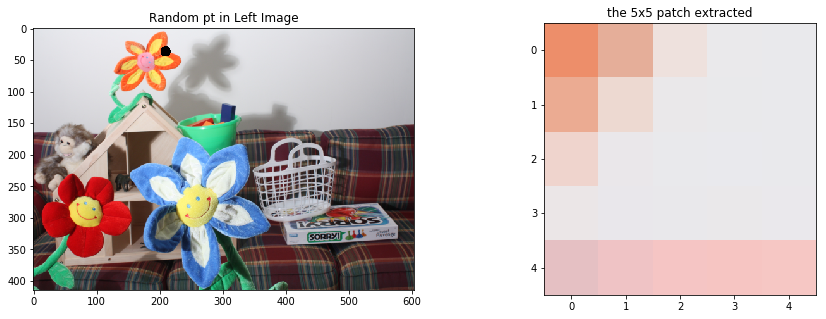

In [10]:

imgL = cv2.imread("im1 (1).png")
imgL_c= cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgL_cc=imgL_c.copy()

#pich a random point from the left img
random_pt = ptsL[120]
print("Random point is :" ) , print(random_pt)

# get the point coordinates
x = random_pt[0]
y = random_pt[1]

start_point = (x-2, y-2) 
end_point = (x+3, y+3) 

# extracte a box of 5x5 around that point from the left img
imgL_box= imgL_cc[y-2:y+3,x-2:x+3]

# show the random point choosen on the left img
image = cv2.rectangle(imgL_c, start_point, end_point, 0, 10) 


# display images
plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(image, cmap="gray")
plt.title("Random pt in Left Image")
plt.subplot(122), plt.imshow(imgL_box, cmap="gray")
plt.title("the 5x5 patch extracted")
plt.show()


Random point is :[[209  36]]
The lines corresponding  to this point is: [[ 3.4693144e-18 -1.0000000e+00  3.6000000e+01]]
y0 = 36,  x0 = 0,  x1 = 603


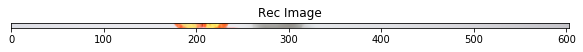

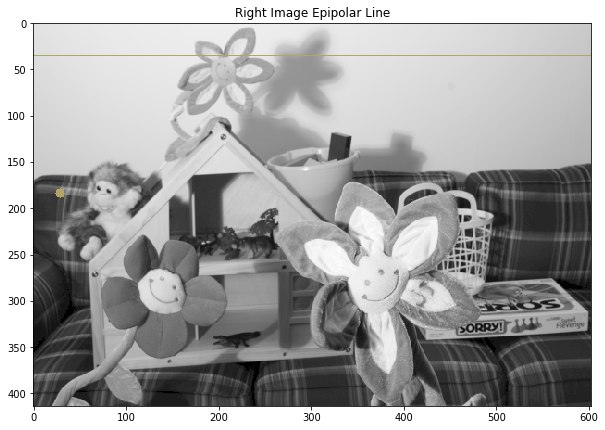

Match is found at point = ( [0] , [234])


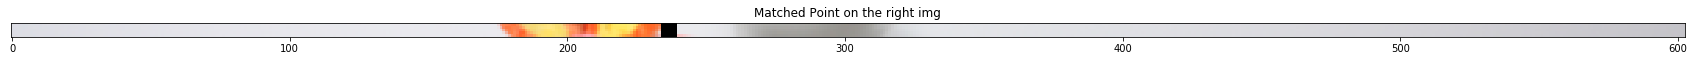

In [11]:
imgL = cv2.imread("im1 (1).png", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("im0 (1).png", cv2.IMREAD_GRAYSCALE)

imgR_c = cv2.imread("im0 (1).png")
imgR_cc= cv2.cvtColor(imgR_c, cv2.COLOR_BGR2RGB)

#convert the random point to a 2d array
random_2d = np.reshape(random_pt, (-1, 2))
print("Random point is :" + str(random_2d))
# compute the line corresponding  to this point on the right img
lineR = cv2.computeCorrespondEpilines(random_2d, 1, F)


lineR = lineR.reshape(-1, 3)
print("The lines corresponding  to this point is: " + str(lineR))

# use the draw line method from the tutorial to drw the line
imgR2, imgL2, y0, x0, x1 = drawlines(imgR, imgL, lineR, ptsR, ptsL)

# the x and y coordinate are extracted as well to know the location of the line (y0 =y1)
print( "y0 = "+ str(y0) + ",  x0 = " + str(x0) + ",  x1 = " +str(x1))

# crop a rectangle around that img with hight 5 around the line and along the x-axis
rec_R = imgR_cc[y0-2:y0+3,x0:x1]

#display the extracted line
plt.figure(figsize=(10,10))
plt.imshow(rec_R, cmap="gray")
plt.title("Rec Image"),plt.yticks([])
plt.show()

# display image with the line drawn 
plt.figure(figsize=(10,10))
plt.imshow(imgR2, cmap="gray")
plt.title("Right Image Epipolar Line")
plt.show()

img = cv2.imread("im0 (1).png")
imgR = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgR_c = rec_R.copy()

# using matchTemplate with the extcted patch and the extracted rec img 
# since the window size is 5x5 this will over this Epipolar Line on 5x5 patches to find a match for the random pt
#normalized cross correlation metric is user for matching as specified
res = cv2.matchTemplate(rec_R, imgL_box, cv2.TM_CCOEFF_NORMED)

ht, wt = imgL_box.shape[0:2]
# set a threshold (need to tune it)
thres = 0.9
# find all points above threshold
# have to decide we want up oe down treshold
loc = np.where(res >= thres)  # return 2D location

# the match was found on this location
print("Match is found at point = ( "  + str(loc[0]) + " , " + str(loc[1]) + ")" )


# loop though the points
# get pixel value (X) and location value (y)
for pt in zip(*loc[::-1]):
    cv2.rectangle(rec_R, pt, (pt[0]+wt, pt[1]+ht), (0,0,0), -1)

# display images
plt.figure(figsize=(30,10))
plt.imshow(rec_R)
plt.title("Matched Point on the right img"), plt.yticks([])
plt.show()

The max correlation value found is: 0.995202362537384at x = 234


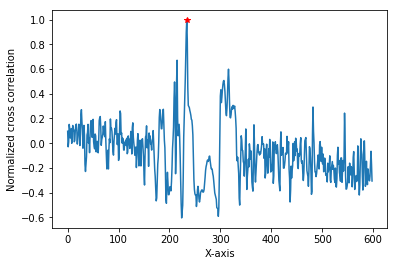

In [12]:

locations = np.where(res)
x_loc = locations[1]
y_loc = locations[0]

#convert the corroletion values and the x-axis values to a list to plot them
res_T = np.transpose(res)
x_loc_list = x_loc.tolist()
res_list = res_T.tolist()

# find the max point and it's location
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

print("The max correlation value found is: " + str(max_val) + "at x = " + str(max_loc[0]))

plt.plot(x_loc_list,res_list)
plt.plot(max_loc[0],max_val, 'r*')
plt.xlabel('X-axis')
plt.ylabel('Normalized cross correlation')
plt.show()


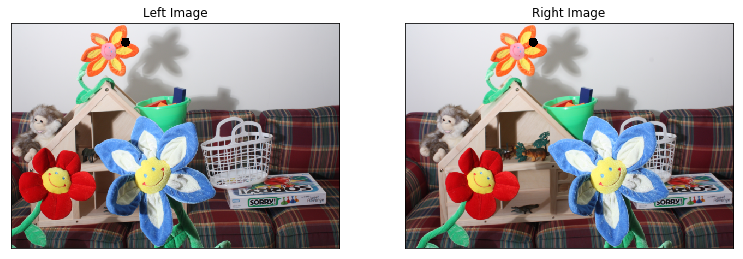

In [13]:
#Display found matching points in both the images
img = cv2.imread("im0 (1).png")
imgR = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# drwaing a rec tangle over the best match found in the right img
x_R = max_loc[0]
y_R=y0
start_point = (x_R-2, y_R-2) 
end_point = (x_R+3, y_R+3) 

image_R = cv2.rectangle(imgR, start_point, end_point, 0, 10) 

plt.figure(figsize=(20,20))
plt.subplot(131), plt.imshow(image)
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(image_R)
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Q)Did you find exactly one matching point or multiple matches? Is the matching point you found the correct one? Explain.

With a threshold set to 0.7 I found 3 adjacent matching point, when the threshold value was increased to 0.9, imposing a higher constrain on the matching, exactly one match point was found.  The matching point found with the higher threshold on the right image match perfectly with the random point chosen from the left image as can be seen in the figures above. 

# part 3 

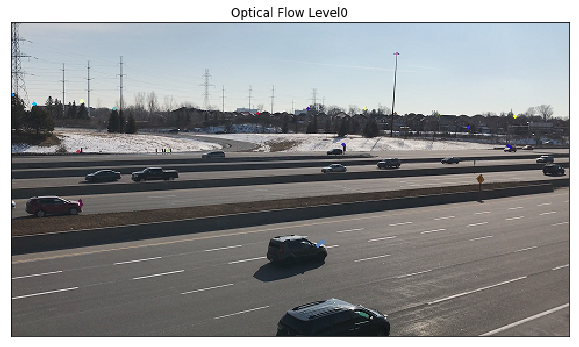

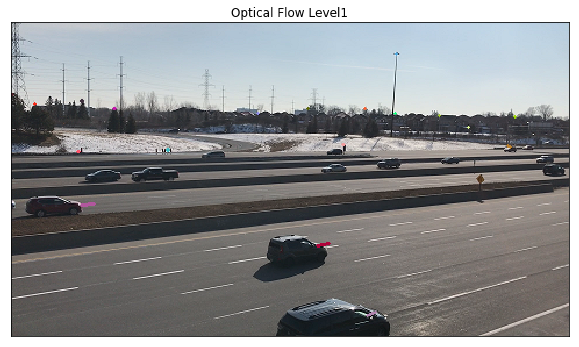

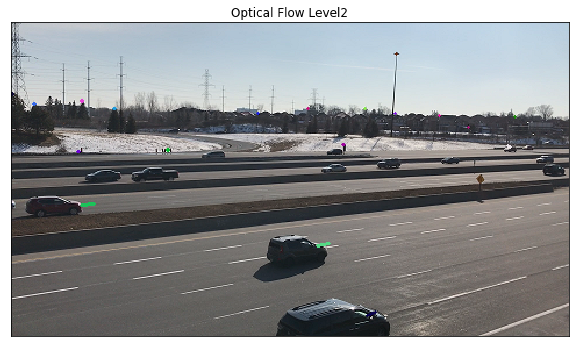

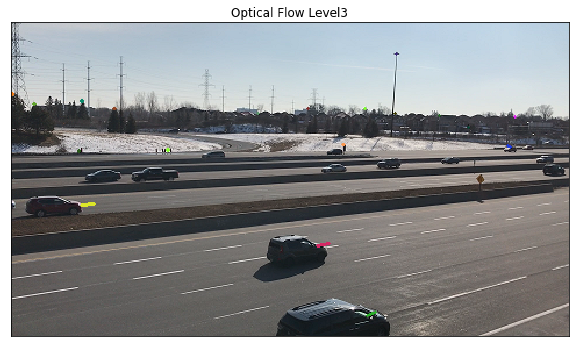

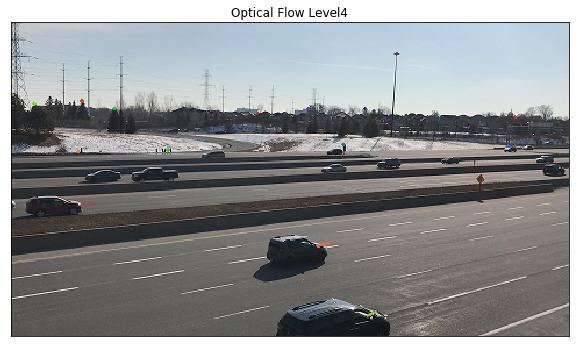

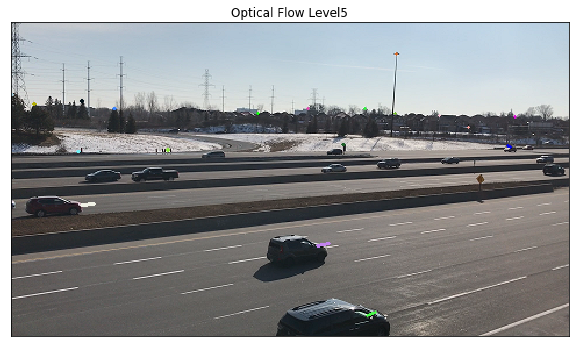

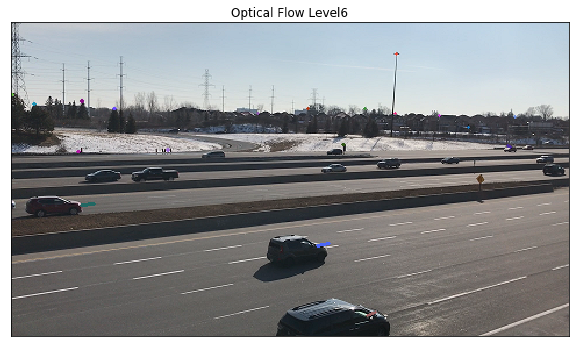

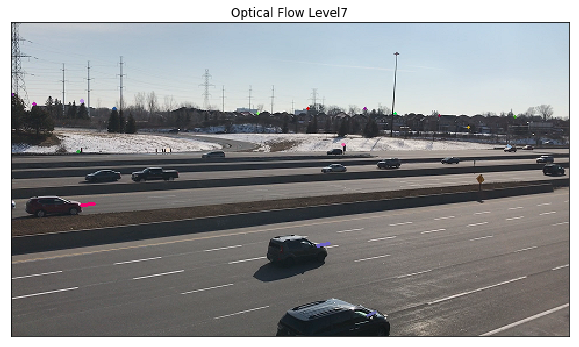

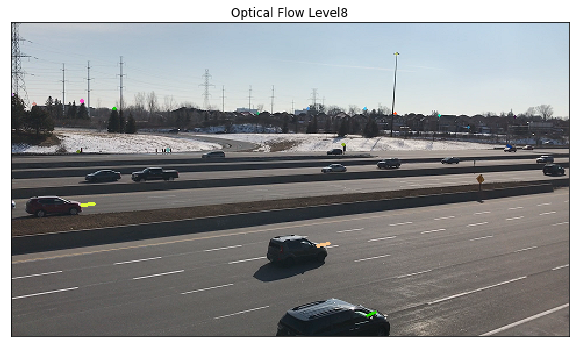

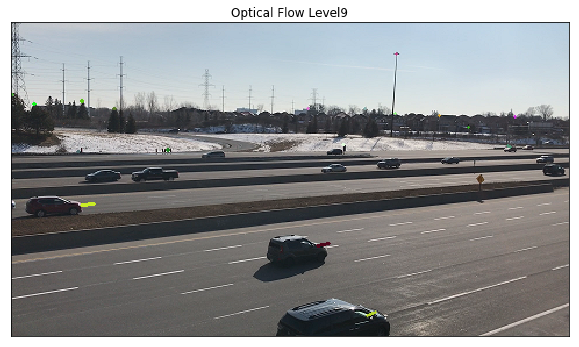

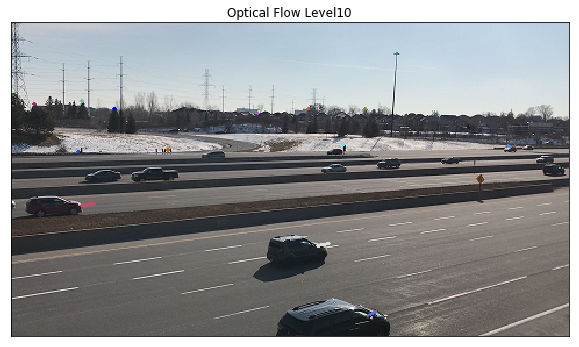

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read images
img1 = cv2.imread("frame1.png")
img2 = cv2.imread("frame2.png")

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

err_list=[]

for k in range(0,11): 
    # parameters for corner detection
    feature_params = dict( maxCorners = 500, # upper limit
                           qualityLevel = 0.2, # threshold for min eigenvalue accepted
                           minDistance =20 ,
                           blockSize = 3 )

    # parameters for lucas kanade optical flow
    lk_params = dict( winSize = (10,10),
                      maxLevel = k,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                                 10, 0.03)) 

    # find good corners in the first image
    p0 = cv2.goodFeaturesToTrack(img1_gray, **feature_params,useHarrisDetector=True)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
    
    mean_err = np.mean(err[st==1])
    err_list.append(mean_err)

    # select good points
    good_new = p1[st==1]  # it might not bee good match but it what the program think is good
    good_old = p0[st==1]

    # create some random colors
    color = np.random.randint(0, 255, (good_new.shape[0], 3))

    # create a mask image for drawing purposes
    mask = img1.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

    
    plt.figure(figsize=(10,10))
    plt.imshow(mask)
    plt.title("Optical Flow Level" + str(k)), plt.xticks([]), plt.yticks([])
    plt.show()

 


[7.4584374, 4.4267764, 4.2583885, 4.581003, 4.612599, 4.612599, 4.612599, 4.612599, 4.612599, 4.612599, 4.612599]


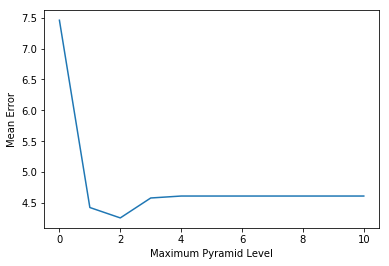

In [15]:
#Plot the mean of the error (on y-axis) vs. pyramid level (on x-axis). 
print(err_list)
x_list = [0,1,2,3,4,5,6,7,8,9,10] 
plt.plot(x_list,err_list)
plt.xlabel('Maximum Pyramid Level')
plt.ylabel('Mean Error')
plt.show()

Q) Discuss the trends you observe in the plot.

Pyramids are used to used to compute large optical flow vectors. With the pyramid the large movment that will go undetected with lucas kanade optical flow can be converted to a small motion in the low-resolution image and thus can be detected by the algorithm . 
Usinga pyramid level of 0 achive a very high error. The best prefirmnace is observed to be at a pyramid level of 2. In general, it's very hard to get an improved preformnace after yhe 3rd pyrmid level. 